In [1]:
import fnmatch
import os
import yaml
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import tempfile
from pprint import pformat, pprint

from ixstools.io import Specfile
from ixstools.fit import gaussian_fit
from ixstools.conf import conf
%matplotlib inline

In [2]:
# Some helpful functions
def make_axes(num_axes):
    ncols = nrows = 1
    if num_axes >= 2:
        ncols = 2
        nrows = int(np.ceil(num_axes/ncols))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))
    return fig, ax
    

In [3]:
# The path to the spec file location
path_to_specfiles = '../ixstools'
# the name of the specific spec file
specfile_name = '20160219.spec'
# name of the x axis
x_name = 'HRM_En'
# the name of the detector(s). Respects standard file globbing
y_names = 'TD*'
# the name of the monitor column
monitors = ['SRcur', 'PD11']
# the scans that you wish to process
scans = [20, 22]
# interpolation mode options are
# 'linear'
# 'nearest'
# 'zero'
# 'slinear'
# 'quadratic
# 'cubic'
# where 'slinear', 'quadratic' and 'cubic' refer to a spline interpolation
# of first, second or third order)
interpolation_mode = 'linear'
# The multiplicative factor to increase (>1) or decrease (<1) the interpolated
# axis
densify_interpolated_axis = 1
# Folder to write the data (respects relative and absolute paths).
# Defaults to 'align_output' folder in current directory
output_dir = 'align_output/'
# The separator in the output files.
# Defaults to space: ' '
output_sep = ','
# Plot *all* plots with a log scale on the y axis.
# Defaults to True
logy = True

In [4]:
specfile = os.path.join(path_to_specfiles, specfile_name)

In [5]:
sf = Specfile(specfile)

### Look at the column names of a specific scan with the "col_names" attribute on a scan number

In [6]:
sf[19].col_names

['HRM_En',
 'H',
 'K',
 'L',
 'Epoch',
 'Seconds',
 'Monitor',
 'PD12',
 'PD13',
 'PD14',
 'PD21',
 'PD22',
 'PD23',
 'PD24',
 'PD31',
 'PD32',
 'PD33',
 'PD34',
 'PD41',
 'PD42',
 'PD43',
 'PD44',
 'PD51',
 'PD52',
 'TD1',
 'TD2',
 'TD3',
 'TD4',
 'TD5',
 'TD6',
 'SC1',
 'SRcur',
 'PD11',
 'Detector']

### Decide what your 'x' axis is

In [7]:
x_name = 'HRM_En'

In [8]:
# make the output directory
os.makedirs(output_dir, exist_ok=True)
sf = Specfile(specfile)
exposure_time = {sid: np.average(sf[sid].scan_data.Seconds) for sid in scans}
metadata = {'exposure time': exposure_time}
# get the dataframes that we care about
# make sure all the scans have the columns that we care about
data = []
y_keys = {}
for sid in scans:
    specscan = sf[sid]
    if not set(monitors) < set(specscan.col_names):
        raise KeyError(
            '{} are the specified monitors and are not a complete subset '
            'of the available columns in scan {}. '
            'Column names in this scan are {} and {} are not in this scan'
            ''.format(monitors, sid, specscan.col_names,
                      set(monitors).intersection(specscan.col_names)))
    if x_name not in specscan.col_names:
        raise KeyError(
            '{} is the specified x axis and is not found in scan {}. '
            'Column names in this scan are {}'.format(
                x_name, sid, specscan.col_names))
    if '*' in y_names:
        # need to check to make sure that all the keys are in all the
        y_keys[sid] = fnmatch.filter(specscan.col_names, y_names)
    else:
        # set(A) < set(B) being True means that A is a subset of B
        # Make sure that all the keys that are specified in the config
        # are in the column names of the spec scan
        # pdb.set_trace()
        if not set(y_names) < set(specscan.col_names):
            raise KeyError(
                '{} are found in the config file under the "y:" section '
                'but are not found in scan {}'
                ''.format(set(y_keys[sid]).difference(specscan.col_names)))
if y_keys:
    keys = list(sorted(y_keys))
    for k1, k2 in zip(keys, keys[1:]):
        if y_keys[k1] != y_keys[k2]:
            print('Scans have different y keys.\nScan {}: {}\nScan{}: {}'
                  ''.format(k1, y_keys[v1], k2, y_keys[k2]))
    y_keys = y_keys[keys[0]]
else:
    y_keys = y_names


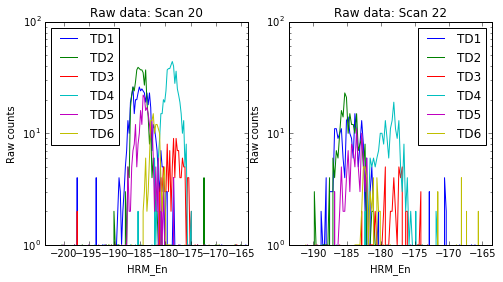

In [9]:
# looks like we made it through the gauntlet!
x_data = [sf[sid].scan_data[x_name] for sid in scans]
y_data = [sf[sid].scan_data[y_keys] for sid in scans]
# output the raw data and make some matplotlib plots
fig, axes = make_axes(len(y_data))
for x_vals, y_sid, sid, ax in zip(x_data, y_data, scans, axes.ravel()):
    fpath = os.path.join(output_dir, '%s-raw' % sid)
    df = y_sid.copy().set_index(x_vals)
    df.to_csv(fpath, output_sep)
    df.plot(logy=logy, ax=ax)
    ax.set_title("Raw data: Scan %s" % sid)
    ax.set_xlabel(x_name)
    ax.set_ylabel("Raw counts")

fpath = os.path.join(output_dir, '-'.join([str(sid) for sid in scans]) + '-raw')
fig.savefig(fpath + '.png')

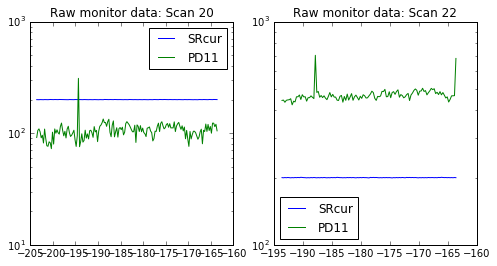

In [10]:
# Extract and plot the raw monitor columns
raw_monitor_data = [[sf[sid].scan_data[monitor] 
                     for monitor in monitors]
                    for sid in scans]
fig, axes = make_axes(len(raw_monitor_data))
for mon_data, x, sid, ax in zip(raw_monitor_data, x_data, scans, axes.ravel()):
    for d, mon in zip(mon_data, monitors):
        ax.semilogy(x, d, label=mon)
    ax.legend(loc=0)
    ax.set_title('Raw monitor data: Scan %s' % sid)

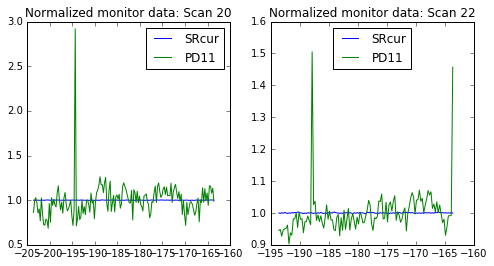

In [11]:
# normalize the monitor by its average value
norm_mon_data = [[d / np.average(d) for d in mon_data] for mon_data in raw_monitor_data]
fig, axes = make_axes(len(raw_monitor_data))
for mon_data, x, sid, ax in zip(norm_mon_data, x_data, scans, axes.ravel()):
    for d, mon in zip(mon_data, monitors):
        ax.plot(x, d, label=mon)
    ax.legend(loc=0)
    ax.set_title('Normalized monitor data: Scan %s' % sid)

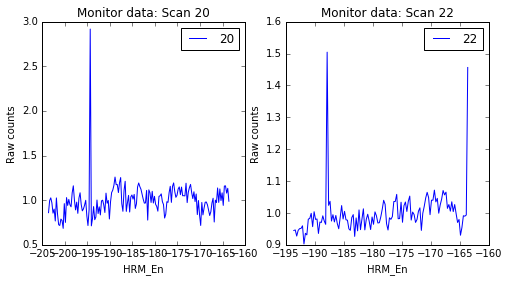

In [12]:
# normalize the monitor by its average value
monitor_data = [np.product(mon_data, axis=0) for mon_data in norm_mon_data]

fig, axes = make_axes(len(monitor_data))
for mon_data, x, sid, ax in zip(monitor_data, x_data, scans, axes.ravel()):
    ax.plot(x, mon_data, label=sid)
    ax.legend(loc=0)
    ax.set_title("Monitor data: Scan %s" % sid)
    ax.set_xlabel(x_name)
    ax.set_ylabel("Raw counts")
    # output the monitor data
    fpath = os.path.join(output_dir, '%s-monitor' % sid)
    pd.DataFrame({'sid': mon_data}, index=x).to_csv(fpath, output_sep)
    
fpath = os.path.join(output_dir, '-'.join([str(sid) for sid in scans]) + '-monitor')
fig.savefig(fpath + '.png')

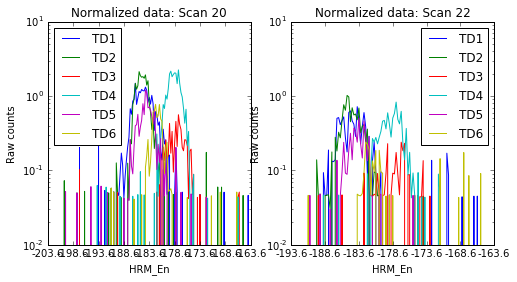

In [13]:
# normalize by the monitor
normed = [y.divide(monitor*ct_time, 'rows')
          for y, monitor, ct_time in zip(y_data, monitor_data, exposure_time)]
fig, axes = make_axes(len(normed))
for df, x, sid, ax in zip(normed, x_data, scans, axes.ravel()):
    df.plot(logy=logy, ax=ax)
    ax.legend(loc=0)
    ax.set_title("Normalized data: Scan %s" % sid)
    ax.set_xlabel(x_name)
    ax.set_ylabel("Raw counts")
    # output the monitor data
    fpath = os.path.join(output_dir, '%s-norm' % sid)
    d.to_csv(fpath, output_sep)


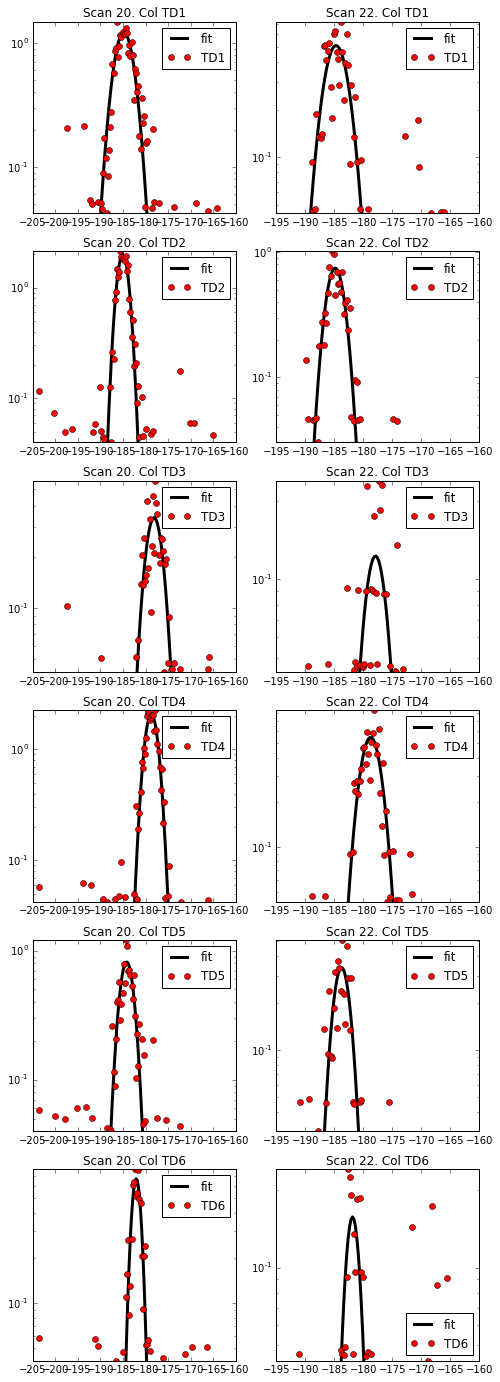

In [23]:
# fit all the data
fits = [[gaussian_fit(x, cols[col_name]) for col_name in cols]
        for x, cols in zip(x_data, normed)]
metadata['fits'] = {}
# output the fit data

fig, axes = plt.subplots(nrows=len(y_keys), ncols=len(scans), figsize=(len(scans)*4, len(y_keys)*4))
for x_vals, normed_df, fit_output, sid, ax_col in zip(x_data, normed, fits, scans, axes.T):
    df_dict = {col_name: f.best_fit.values for col_name, f in zip(y_keys, fit_output)}
    df = pd.DataFrame(df_dict, index=x_vals)
    for ax, fit_col_name, normed_col_name in zip(ax_col, df, normed_df):
        ax.semilogy(df.index, df[fit_col_name], label='fit', 
                    marker='', linewidth=3, color='k')
        ax.semilogy(normed_df.index, normed_df[normed_col_name], 
                    'ro', label=normed_col_name,linestyle='None')
        curmax = np.max(normed_df[normed_col_name])
        curmin = normed_df[normed_col_name].dropna()[normed_df[normed_col_name] != 0].min()
        ax.set_ylim([curmin, curmax])
        ax.legend(loc=0)
        ax.set_title('Scan %s. Col %s' % (sid, normed_col_name))
#         normed_df.plot(y=normed_col_name, logy=logy, ax=ax)
#         pdb.set_trace()
    fpath = os.path.join(output_dir, '-'.join([str(sid), 'fit']))
    df.to_csv(fpath, output_sep)
    metadata['fits'][sid] = {
        col_name: f.fit_report() for col_name, f in zip(y_keys, fit_output)
    }
    
# write metadata to file
fname = '-'.join([str(sid) for sid in scans]) + 'metadata'
with open(os.path.join(output_dir,  fname), 'w') as f:
    f.write(pformat(metadata))
    
fpath = os.path.join(output_dir, '-'.join([str(sid) for sid in scans]) + '-fit')
fig.savefig(fpath + '.png')

In [ ]:

# zero everything
zeroed = [
    [(np.array(f.userkws['x'] - f.params['center'], dtype=float), f.data)
     for f in fit] for fit in fits]
# output the zeroed data
for zeroed_vals, sid in zip(zeroed, scans):
    fpath = os.path.join(output_dir, '-'.join([str(sid), 'zeroed']))
    col_names = [['x-%s' % col_name, 'y-%s' % col_name] for col_name in y_keys]
    df_dict = {col_name: col
               for col_name_pair, xy in zip(col_names, zeroed_vals)
               for col_name, col in zip(col_name_pair, xy)}
    pd.DataFrame(df_dict).to_csv(fpath, output_sep)

# compute the average difference between data points
diff = np.average([np.average([np.average(np.diff(x)) for x, y in z]) for z in zeroed])
minval = np.min([np.min([np.min(x) for x, y in z]) for z in zeroed])
maxval = np.max([np.max([np.max(x) for x, y in z]) for z in zeroed])
# compute the new axes
new_axis = np.arange(minval, maxval, diff / densify_interpolated_axis)
# set up the interpolators
interpolators = [[interp1d(x, y, kind=interpolation_mode,
                           bounds_error=False,
                           fill_value=np.nan)
                  for x, y in z] for z in zeroed]

# Create the interpolated values categorized by scan
interpolated = [
    pd.DataFrame({col_name: interp(new_axis) for col_name, interp in
                  zip(y_keys, interpolator)},
                 index=new_axis) for interpolator in interpolators]


# output the interpolated data
for interp_df, sid in zip(interpolated, scans):
    fpath = os.path.join(output_dir, '-'.join([str(sid), 'interpolated']))
    interp_df.to_csv(fpath, output_sep)

summed_by_scan = pd.DataFrame({
    sid: interp_df.dropna().sum(axis=1)
    for sid, interp_df in zip(scans, interpolated)}, index=new_axis)
# sum by detector
summed_by_detector = pd.DataFrame({
    det_name: np.sum([df[det_name].values for df in interpolated], axis=0)
    for det_name in list(y_data[0].columns)}, index=new_axis)
# fit the summed by scan curves
# pdb.set_trace()
summed_by_scan_fit = {}
fits = {}
for sid in summed_by_scan:
    series = summed_by_scan[sid].dropna()
    f = gaussian_fit(series.index.values, series.values)
    fits[sid] = f
    summed_by_scan_fit[sid] = pd.DataFrame({sid: f.best_fit}, index=series.index.values)
    # pdb.set_trace()
# summed_by_scan_fit = pd.DataFrame(fit_dict, index=series.index.values)
# summed_by_scan_fit = [fit(np.asarray(summed_by_scan.index),
#                           np.asarray(summed_by_scan[sid].values))
#                       for sid in summed_by_scan]
# summed_by_detector_fit = [fit(np.asarray(summed_by_detector.index),
#                               summed_by_detector[sid].values)
#                           for sid in summed_by_detector]
# output the summed data
# pdb.set_trace()
fpath = os.path.join(output_dir, '-'.join([str(sid) for sid in scans] + ['summed']))
summed_by_scan.to_csv(fpath + '-by-scan', output_sep)
summed_by_detector.to_csv(fpath + '-by-detector', output_sep)
summed_by_scan.dropna().sum(axis=1).to_csv(fpath + '-all', output_sep)

fig, axes = plt.subplots(ncols=1)
try:
    len(axes)
except TypeError:
    axes = [axes]
if logy:
    plotfunc = 'semilogy'
else:
    plotfunc = 'plot'
maxval = 0
minval = 1
for ax, df, df_fit, title, in zip(
        axes,
        [summed_by_scan, summed_by_detector],
        [summed_by_scan_fit],#, summed_by_detector]
        ["Aligned and summed by scan", "Aligned and summed by detector"]):
    for col_name, c in zip(df, ['b', 'g', 'k', 'y', 'o', 'r']):
        getattr(ax, plotfunc)(df[col_name], label=str(col_name),
                              marker='o', markerfacecolor=c, linestyle='None')
        #pdb.set_trace()
        curmax = np.max(df[col_name])
        maxval = curmax if curmax > maxval else maxval
        curmin = df[col_name].dropna()[df[col_name] != 0].min()
        minval = curmin if curmin < minval else minval
        getattr(ax, plotfunc)(df_fit[col_name], label=str(col_name)+'-fit',
                              marker='', linestyle='-', linewidth=1,
                              color=c)
        fwhm = fits[col_name].params['fwhm']
        print('FWHM for %s: %.4g +/- %.2g' % (col_name, fwhm.value, fwhm.stderr))
    ax.legend(loc=1)
    ax.set_title(title)
    ax.set_xlabel(r'$\Delta$E')
    ax.set_ylim([minval, maxval])
    ax.set_ylabel("Normalized counts per second")
    ax.axvline(linewidth=3, color='k', linestyle='--')
fname = '-'.join([str(s) for s in scans] + ['final']) + '.png'
plt.savefig(os.path.join(output_dir, fname))
plt.show()